In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import workhorse as wh
import sentinnel_tools as st

# IMPORT AND FLAG DATA

In [3]:
# Take RDI textfile and convert to xarray dataset
adcp1 = st.WinADCP_to_dataset('ADCP/ADCP01_all.txt')
adcp2 = st.WinADCP_to_dataset('ADCP/ADCP02_all.txt')

# Conduct quality assurance tests and flag data
adcp1 = st.adcp_qc(adcp1)
adcp2 = st.adcp_qc(adcp2)

# Export to netcdf for future use
adcp1.to_netcdf('ADCP/adcp1.nc')
adcp2.to_netcdf('ADCP/adcp2.nc')

Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Cannot conduct BIT test because variable does not exist in dataset


# Plotting

<ipython-input-4-63ea2cca8a4a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.East,norm=norm)


(array([19198., 19202., 19205., 19209., 19213., 19217.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

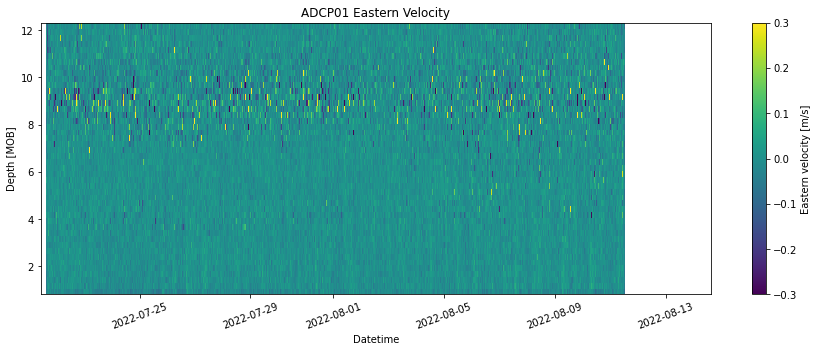

In [4]:
# Across shore colorplot
plt.figure(figsize = (15,5))
minvel = -.3 # Limits for the colorbars used on the adcp colorplots
maxvel = .3
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP01 Eastern Velocity')
plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.East,norm=norm)
plt.colorbar(label='Eastern velocity [m/s]')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

<ipython-input-5-b7e8ed66cd70>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.Flag,norm=norm)


(array([19198., 19202., 19205., 19209., 19213., 19217.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

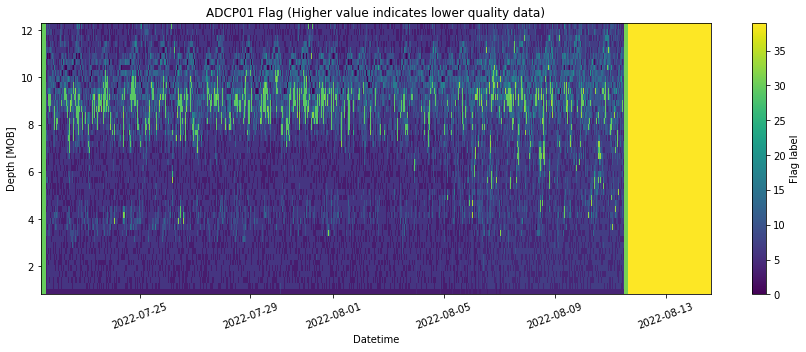

In [5]:
# Across shore colorplot
plt.figure(figsize = (15,5))
norm = matplotlib.colors.Normalize()
#minvel = 3 # Limits for the colorbars used on the adcp colorplots
#maxvel = 46
#norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP01 Flag (Higher value indicates lower quality data)')
plt.pcolormesh(adcp1.time, adcp1.BinDist, adcp1.Flag,norm=norm)
plt.colorbar(label='Flag label')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

<ipython-input-151-77aed14c5c3c>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.East,norm=norm)


(array([19228., 19229., 19230., 19231., 19232., 19233., 19234.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

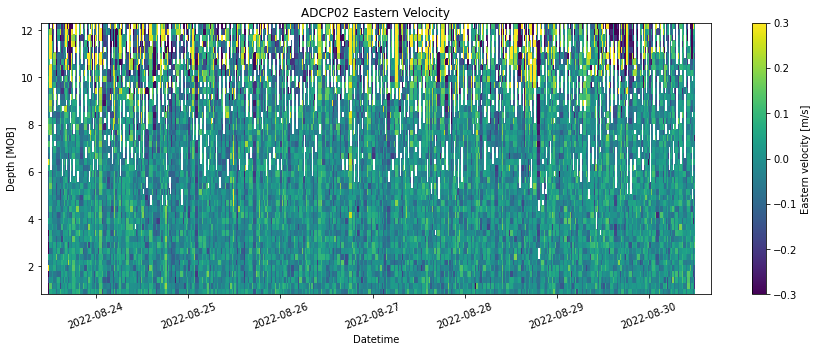

In [151]:
# Across shore colorplot
plt.figure(figsize = (15,5))
minvel = -.3 # Limits for the colorbars used on the adcp colorplots
maxvel = .3
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP02 Eastern Velocity')
plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.East,norm=norm)
plt.colorbar(label='Eastern velocity [m/s]')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

<ipython-input-153-24eba4ca83ca>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.Flag,norm=norm)


(array([19228., 19229., 19230., 19231., 19232., 19233., 19234.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

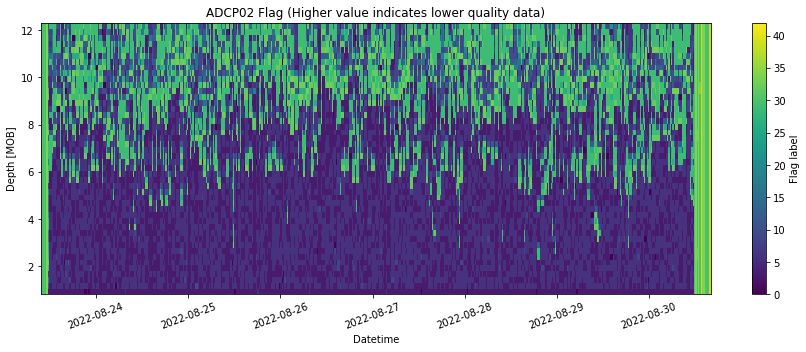

In [153]:
# Across shore colorplot
plt.figure(figsize = (15,5))
norm = matplotlib.colors.Normalize()
#minvel = 3 # Limits for the colorbars used on the adcp colorplots
#maxvel = 46
#norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.title('ADCP02 Flag (Higher value indicates lower quality data)')
plt.pcolormesh(adcp2.time, adcp2.BinDist, adcp2.Flag,norm=norm)
plt.colorbar(label='Flag label')
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation='20')
#plt.gca().invert_yaxis()

# BEAM COORDINATES

In [ ]:
# Import the beam coordinate csv's
b1 = pd.read_csv('ADCP/SWC2_000_1_export.csv')
b2 = pd.read_csv('ADCP/SWC2_000_2_export.csv')
b3 = pd.read_csv('ADCP/SWC2_000_3_export.csv')
b4 = pd.read_csv('ADCP/SWC2_000_4_export.csv')

In [ ]:
# Combine the csv's in chronological order
#data = b1.append(b2)
#data = data.append(b3)
#data = data.append(b4)
#data = data.reset_index(drop=True)
#data = data.drop(columns=['index'])
#data.to_csv('ADCP/beam_data.csv', index=False)
data = pd.read_csv('ADCP/beam_data.csv')

In [ ]:
vel = data.filter(like='V')

In [ ]:
vel_B1 = vel.filter(like='B1')
vel_B2 = vel.filter(like='B2')
vel_B3 = vel.filter(like='B3')
vel_B4 = vel.filter(like='B4')

In [ ]:
time = pd.to_datetime(data.iloc[:,1])
dcell = range(1,48,1)

In [ ]:
B1_arr = vel_B1.to_numpy()
B2_arr = vel_B2.to_numpy()
B3_arr = vel_B3.to_numpy()
B4_arr = vel_B4.to_numpy()

In [ ]:
# create coords
rows = range(1,48,1) 
cols = time

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        B1=(["time", "dcell"], B1_arr),
        B2=(["time", "dcell"], B2_arr),
        B3=(["time", "dcell"], B3_arr),
        B4=(["time", "dcell"], B4_arr)
    ),
    coords=dict(
        dcell=(["dcell"], rows),
        time=(["time"], cols),
    ),
    attrs=dict(description="Velocity in beam coordinates"),
)

In [ ]:
ds['B1'].attrs['units'] = 'mm/s'
ds['B2'].attrs['units'] = 'mm/s'
ds['B3'].attrs['units'] = 'mm/s'
ds['B4'].attrs['units'] = 'mm/s'

In [ ]:
ds